In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno 
from pytz import timezone
import re
import pytz

In [40]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn import svm
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.utils import class_weight
from sklearn.utils.extmath import density
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from time import time

In [6]:
df = pd.read_csv('SolarPrediction.csv')
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
UNIXTime                  32686 non-null int64
Data                      32686 non-null object
Time                      32686 non-null object
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
TimeSunRise               32686 non-null object
TimeSunSet                32686 non-null object
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


From these we can see that 4 datetime columns are strings instead of datetime objects

In [8]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


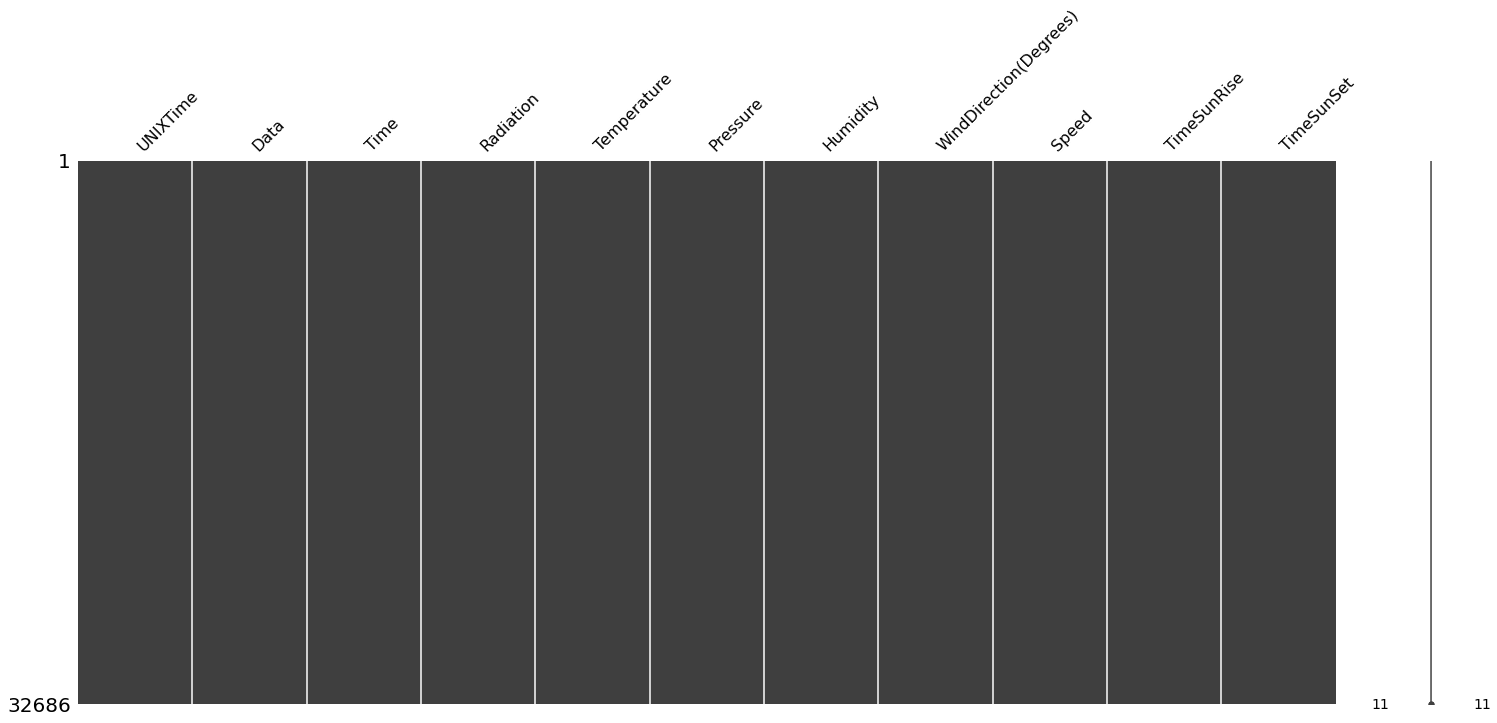

In [9]:
missingno.matrix(df)

In [10]:
def preprocess_data(df):

    """
    Description:
        Convert timezone to Hawaii
        Rename some of the columns
        Convert string columns to datetime objects
        add new feature from TimeSunSet and TimeSunRise columns
    
    Args:
        val: input df (DataFrame)
        
    Returns:
        df -> preprocessed DataFrame
    """

    # 'Data' - all elements contain the same value.
    # we have UNIXTime so we can drop Time.
    df.drop(['Data','Time'],axis=1,inplace=True)

    # index by UNIX time
    df['UNIXTime'] = pd.to_datetime(df['UNIXTime'], unit='s')
    df.sort_values('UNIXTime', inplace=True) # sort by UNIXTime
    df.set_index('UNIXTime',inplace=True) # index by UNIXTime
    
     # Localize the index (using tz_localize) to UTC (to make the Timestamps timezone-aware) and then convert to Eastern (using tz_convert)
    hawaii= timezone('Pacific/Honolulu')
    df.index = df.index.tz_localize(pytz.utc).tz_convert(hawaii)

    #rename some of the columns
    df.rename(columns={'WindDirection(Degrees)': 'WindDirection', 'Speed': 'WindSpeed'}, inplace=True)

    #convert string columns to datetime objects
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.week
    df['month'] = df.index.month
    df['hour'] = df.index.hour 
    df['Date'] = df.index.date

    #extract sunrise and sunrise hour and minute
    df['SunriseHour'] = df['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
    df['SunriseMinute'] = df['TimeSunRise'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

    df['SunsetHour'] = df['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
    df['SunsetMinute'] = df['TimeSunSet'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

    df.drop(['TimeSunRise', 'TimeSunSet'],axis=1,inplace = True)



    
    
    return df

In [11]:
df = preprocess_data(df)
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection,WindSpeed,day_of_month,week_of_year,month,hour,Date,SunriseHour,SunriseMinute,SunsetHour,SunsetMinute
UNIXTime,,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,2.58,51,30.43,103,77.27,11.25,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:05:10-10:00,2.83,51,30.43,103,153.44,9.00,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:20:06-10:00,2.16,51,30.43,103,142.04,7.87,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:25:05-10:00,2.21,51,30.43,103,144.12,18.00,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:30:09-10:00,2.25,51,30.43,103,67.42,11.25,1,35,9,0,2016-09-01,6,7,18,38


In [23]:
#df.hist(column='Temperature', grid=True)
df['Temperature'].min()
#df.hist(column='WindDirection', grid=True)
df['WindDirection'].min()
# Wind direction can be divided in bins maybe
# Wind speed greater than 15 only 480 values
df['Radiation'] = df['Radiation'].astype(int)

In [13]:
#df['WindDirection'] = df['WindDirection'].apply(lambda x: int(x)).apply(lambda x: 'NE' if (x>0 & x<=90) else ('SE' if (x>90 & x<=180) else ('SW' if (x>180 & x<=270) else 'NW')))
bins = [0,90,180,270,360]
names = [1,2,3,4] #['NE','SE','SW','NW']
df['WindDirectionNew'] = pd.cut(df['WindDirection'], bins, labels=names).cat.codes


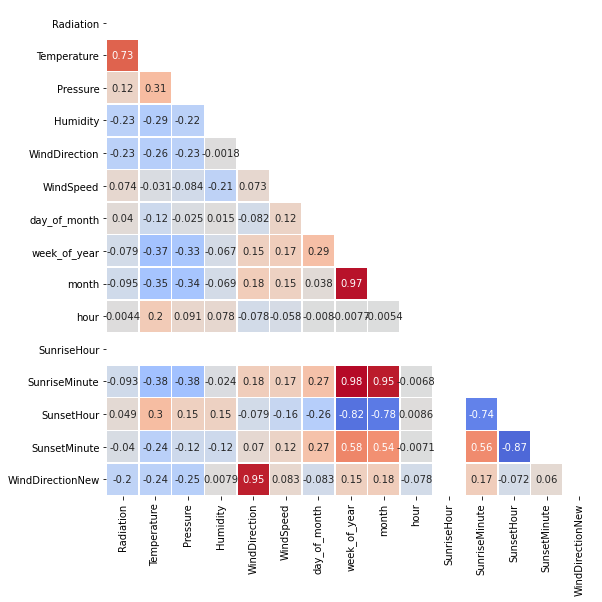

In [14]:
plt.figure(figsize=(12,9))
corr = df.corr() # Compute the correlation matrix
mask = np.zeros_like(corr, dtype=np.bool) # make mask
mask[np.triu_indices_from(mask)] = True # mask upper triangle
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=.5, annot=True, cbar=False)

# ML with sklearn starts here

In [46]:
# Here are some helper functions that will be used for classification
# Some of them are default functions from sklearn library

def benchmark(clf,train_x_,train_y_,test_x_,test_y_):
  """
  Function to train, fit and predict
  Returns dictionary with classifier information
  """
  results = {}
  for clf, name in (clf):
    print('=' * 80)
    print(name)
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(train_x_, train_y_)
    train_time = str(time() - t0)
    print(f"train time: {train_time}" )
    t0 = time()
    pred = clf.predict(test_x_)
    test_time = str(time() - t0)
    print(f"test time:  {test_time}")
    score = mean_squared_error(test_y_, pred)
    print("MSE: ", score)

    results.update({name:[clf.get_params(), score, train_time, test_time]})
  return results
  
def plt_clf(results,title="Score"):
  """
  Function for plotting the score and time of classifiers
  """
  indices = np.arange(len(results))
  name = [i for i in results]
  score = [j[1] for j in [results[i] for i in results]]
  training_time = [j[2] for j in [results[i] for i in results]]
  test_time = [j[3] for j in [results[i] for i in results]]
  training_time_ind = np.array(training_time).astype(np.float)
  test_time_ind = np.array(test_time).astype(np.float)
  training_time_ind = training_time_ind / np.max(training_time_ind)
  test_time_ind = test_time_ind / np.max(test_time_ind)
  plt.figure(figsize=(12, 8))
  plt.title(title)
  plt.barh(indices, score, .2, label="Score", color='navy')
  plt.barh(indices + .3, training_time_ind, .2, label="Training time", color='c')
  plt.barh(indices + .6, test_time_ind, .2, label="Test time", color='darkorange')
  plt.yticks(())
  plt.legend(loc='best')
  plt.subplots_adjust(left=.25)
  plt.subplots_adjust(top=.95)
  plt.subplots_adjust(bottom=.05)
  for i in indices:
    plt.text(-.3, i,  f"{name[i]}\n"
                      f"Score: {np.round(score[i],8)}\n"
                      f"Training time: {np.round(float(training_time[i]),2)}\n"
                      f"Test time: {np.round(float(test_time[i]),2)}")
  plt.show()


def gridsearch(pipe,para,train_x_,train_y_, cv = 5, plot=True):
  """
  Function gridsearch as well as plotting the result
  """
  stopwatch = datetime.now()
  grid = GridSearchCV(pipe, para, n_jobs=-1, verbose=1, cv = cv, return_train_score=True)#, scoring="accuracy")
  #grid = RandomizedSearchCV(pipe, para, n_jobs=-1, verbose=1, cv = cv, return_train_score=True,random_state=101)#, scoring="accuracy")
  grid.fit(train_x_,train_y_)

  #metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
  grid_results={}
  para = []
  paraname= []
  for i,k in enumerate(list(zip(*grid.param_grid.items()))[1]):
    if len(k)>1:
      para.append(k)
      paraname.append((list(zip(*grid.param_grid.items()))[0][i]))
  #longest=max((len(l), i) for i, l in enumerate(para))[1]
  secondlongest = 0
  if len(para) >1:
    secondlongest = [len(i) for i in para]
    secondlongest.remove(sorted(secondlongest)[-1])
    secondlongest = np.argmax(secondlongest)
  
  for i,dic in enumerate(grid.cv_results_["params"]):
    score = grid.cv_results_["mean_test_score"][i]
    train_time = grid.cv_results_["mean_fit_time"][i]
    test_time = grid.cv_results_["mean_score_time"][i]
    title ,name= "",""
    for k,v in dic.items():
      if k in paraname:
        ksplit = k.split(grid.estimator.steps[-1][0]+"__")[-1]+" :"+str(v)+" "
        if len(para) >1 and  sum((len(l)) for l in para) >4:
          if k == paraname[secondlongest]:
            title=f"Result grouped by {ksplit}"
            continue
        else:
          title="Result"
        name += ksplit
    if title not in grid_results:
        grid_results.update({title:[[name, score, train_time, test_time,name]]})
    else:
      grid_results[title].append([name, score, train_time, test_time,name])
  if plot:
    for i in grid_results:
      p={}
      for j,k in enumerate(grid_results[i]):
        p.update({k[0]:k})
      print("_"*100)
      plt_clf(p,f"{i}")
      print("_"*100)         
  print("Best score: {:.2f}".format(grid.best_score_))
  print("Best parameters: ", grid.best_params_)
  print(f"Time: {datetime.now() - stopwatch}")
  #return grid
  return (grid.best_estimator_[-1].get_params())

In [26]:
# Splitting data and selecting columns we want to use for classification

columns = ['Pressure','Humidity','WindDirection','WindSpeed']
df = df[columns]

train_x, test_x, train_y, test_y = train_test_split(df,df["Radiation"], test_size=0.3, random_state=101, shuffle=True)

In [47]:
classifiers = [
           (SGDRegressor(), "SGDClassifier"),

           (AdaBoostRegressor(), "AdaBoostClassifier"),

           (GradientBoostingRegressor(), "GradientBoostingClassifier"),

           (XGBRegressor(), "XGBregressor"),

           (LinearRegression(), "LinearRegression"),

           (RandomForestRegressor(max_depth=10), "Random forest"),

           (DecisionTreeRegressor(max_depth=10), "Decision Tree"),

           (LinearSVR(), "Linear SVR")
]
results = benchmark(classifiers[::-1],train_x, train_y, test_x, test_y)

#plt_clf(results)

Linear SVR
________________________________________________________________________________
Training: 
LinearSVR()
train time: 0.023003578186035156
test time:  0.0040013790130615234
MSE:  3.8370833068998955e-16
Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeRegressor(max_depth=10)
train time: 0.09299898147583008
test time:  0.005998373031616211
MSE:  2.331344618530007
Random forest
________________________________________________________________________________
Training: 
RandomForestRegressor(max_depth=10)
train time: 4.89706015586853
test time:  0.11099672317504883
MSE:  2.741341740840562
LinearRegression
________________________________________________________________________________
Training: 
LinearRegression()
train time: 0.007001161575317383
test time:  0.003998517990112305
MSE:  1.3298748881837266e-26
XGBregressor
________________________________________________________________________________
Training: 
XGB

In [ ]:
# Parameter tuning with gridsearch
cv = 3
gridplot = True

In [ ]:
pipeline = Pipeline(steps=[
  ("svc", LinearSVC())
  ])

parameters = {"select__score_func": [chi2],
              "svc__dual": [True,False],
              "svc__C": [1e-2, 1e-1, 1e0, 1e1, 1e2]}

LinearSVC_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv, plot=gridplot)